## Developing KNN code

In [1]:
# General imports
import torch
import numpy as np
import os, sys
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image

In [2]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json
from parse_config import ConfigParser
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer.editor import Editor
from utils import prepare_device, copy_file, read_paths #, show_image
from utils.visualizations import show_image
# sys.path.insert(0, os.path.join('external_code', 'EditingClassifiers'))
# from helpers.context_helpers import fea

In [3]:
# Define constants, paths
config_path = 'configs/debug/cinic10_imagenet_edit_debug.json'
base_image_path = 'data/editing/dummy/tank1.jpg'

In [4]:
# Load config file, models, and dataloader
config_json = read_json(config_path)
config = ConfigParser(config_json)

layernum = config.config['layernum']
model = config.init_obj('arch', module_arch, layernum=layernum)

val_data_loader = config.init_obj('data_loader', module_data, split='valid')
test_data_loader = config.init_obj('data_loader', module_data, split='test')

In [42]:
# Load and resize image
def load_image(image_path, resize=None):
    image = Image.open(image_path).convert("RGB")
    if resize is not None:
        image = image.resize(resize)
        show_image(image)
    # Convert to numpy array
    image = np.asarray(image, float)

    # Make channels C x H x W
    image = np.transpose(image, (2, 0, 1))

    # Normalize between [0, 1]
    image = image / 255.0
    
    return image

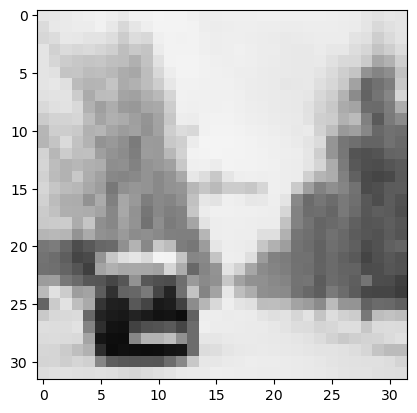

torch.Size([3, 32, 32])


In [43]:
# Load base image and convert to tensor

base_image = load_image(base_image_path, resize=(32, 32))
base_image = torch.tensor(base_image).type(torch.float32)
print(base_image.shape)
# base_image = torch.nn.functional.interpolate(base_image, (3, 32, 32))

In [26]:
# Function definitions
def prepare_knn(data_loader, model, base_image=None, data_type='features'):
    '''
    Obtain nearest neighbors for each image in data loader and base image (if not None)

    Arg(s):
        K : int
            how many neighbors to calculate
        data_loader : torch.utils.DataLoader
            shuffle should be false
        model : torch.nn.module
            model
        base_image : torch.tensor or None
            specific image to calculate neighbors for
        data_type : str
            for what data we want to calculate KNN for -- features, logits, images
    '''
    assert data_type in ['features', 'logits', 'images'], "Unsupported data type {}".format(data_type)
    assert not model.training
    assert model.__class__.__name__ == 'CIFAR10PretrainedModelEdit'

    all_data = []
    image_paths = []
    labels = []
    return_paths = data_loader.get_return_paths()
    context_model = model.context_model

    with torch.no_grad():
        # First element in all_data will be the base_image representation if it's not None
        if base_image is not None:
            base_image = torch.unsqueeze(base_image, dim=0)
            base_image = base_image.to(device)
            if data_type == 'images':
                # all_data.append(base_image)
                base_data = base_image
            else:
                logits = context_model(base_image)

                if data_type == 'logits':
                    base_data = logits
                elif data_type == 'features':
                    features = model.get_feature_values()
                    post_features = features['post']
                    base_data = post_features
            
            # Flatten to a 1-D vector
            base_data = base_data.reshape([1, -1]) 

        # Obtain features from dataset
        for idx, item in enumerate(tqdm(data_loader)):
            if return_paths:
                image, label, path = item
                # Add label and path to lists
                path = list(path)
                image_paths += path
                labels.append(np.asarray(label))
            else:
                image, label = item
            
            
            # If we only want images, don't bother running model
            if data_type == 'images':
                all_data.append(image)
                continue

            # If not image, forward it through the model
            image = image.to(device)
            logits = context_model(image)
            
            if data_type == 'logits':
                all_data.append(logits)
            elif data_type == 'features':
                features = model.get_feature_values()
                post_features = features['post']
                
                print("post_features.shape {}".format(post_features.shape))
                all_data.append(post_features)

    # Concatenate, reshape to 1-D vectors, and convert features/logits/images to numpy
    all_data = torch.cat(all_data, dim=0)
    all_data = all_data.reshape([all_data.shape[0], -1])
    all_data = all_data.cpu().numpy()
    assert len(all_data.shape) == 2
    
    # Concatenate labels
    labels = np.concatenate(labels, axis=0)
    
    if base_image is None:
        return all_data, labels, image_paths

    else:
        base_data = base_data.cpu().numpy()
        return all_data, labels, image_paths, base_data

def get_k_nearest_neighbors(K, data, labels, point):
    '''
    Given a data point and data, return the indices of the K nearest neighbors
    
    Arg(s):
        K : int
            number of neighbors to return
        data : N x ... np.array
            data from dataset to find neighbors from
        point : 1 x ... np.array 
            point to find all neighbors for, same shape except in dim=0 as data
            
    Returns:
        tuple(list[int], list[float])
            tuple of 2 K length lists of indices and corresponding distances 
                from data that correspond with nearest neighbors to point
    '''
    KNN = KNeighborsClassifier(n_neighbors=K)
    KNN = KNN.fit(data, labels)
    indices, distances = KNN.kneighbors(point)
    
    return indices, distances

In [27]:
# Pedal to the metal!

# Prepare for (multi-device) GPU training
device, device_ids = prepare_device(config['n_gpu'])
model = model.to(device)
if len(device_ids) > 1:
    model = torch.nn.DataParallel(model, device_ids=device_ids)
model.eval()  # model should always be in eval() for editing

# Prep data by obtaining appropriate features
K = 10
data_type = 'features'
all_data, labels, image_paths, base_data = prepare_knn(
    data_loader=val_data_loader,
    model=model,
    base_image=base_image,
    data_type=data_type
)

 31%|███████████████████████████▊                                                             | 5/16 [00:00<00:01,  8.76it/s]

post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])


 75%|██████████████████████████████████████████████████████████████████                      | 12/16 [00:00<00:00, 18.31it/s]

post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([64, 512, 1, 1])


100%|████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.26it/s]

post_features.shape torch.Size([64, 512, 1, 1])
post_features.shape torch.Size([40, 512, 1, 1])


In [34]:
# print(len(image_paths))
# print(type(image_paths[0]))
# print(labels.shape)
print(base_data.shape)
distances, indices = knn(
    K=K,
    data=all_data,
    labels=labels,
    point=base_data)
print(indices[0])

(1, 512)
[871 886 810 843 818 866 834 808 880 863]


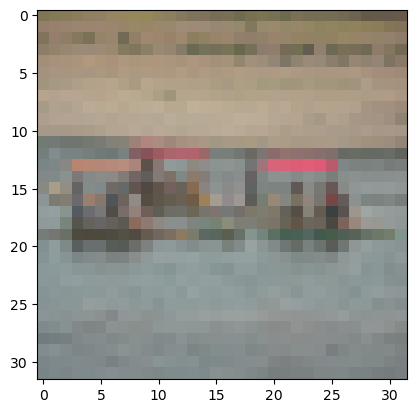

8


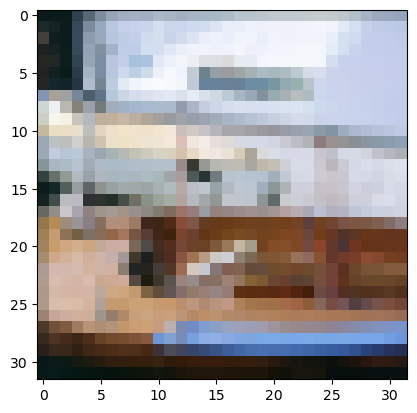

8


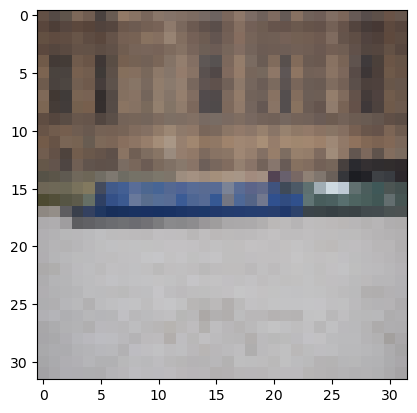

8


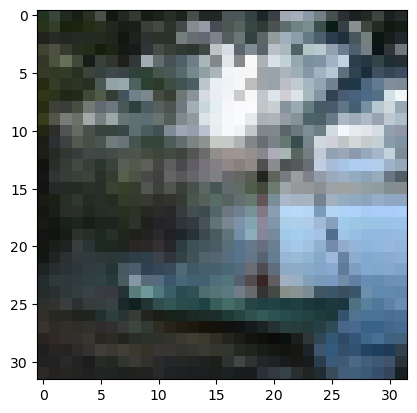

8


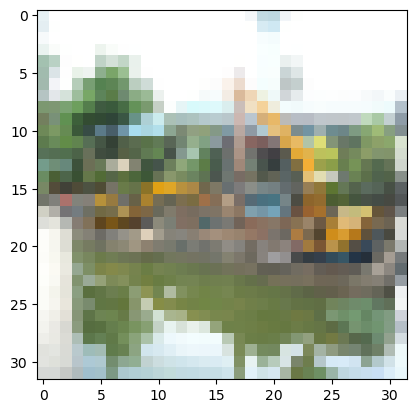

8


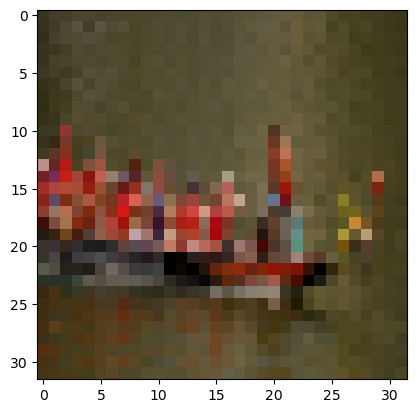

8


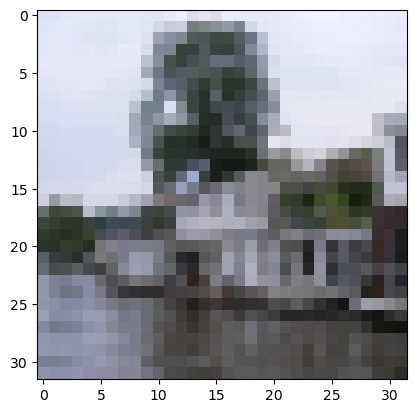

8


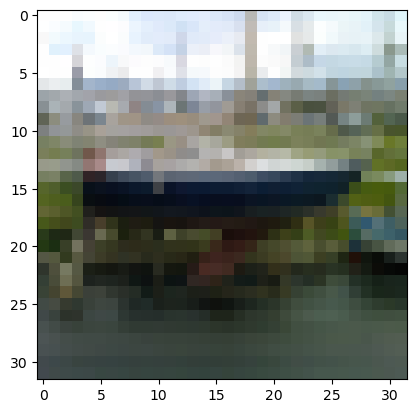

8


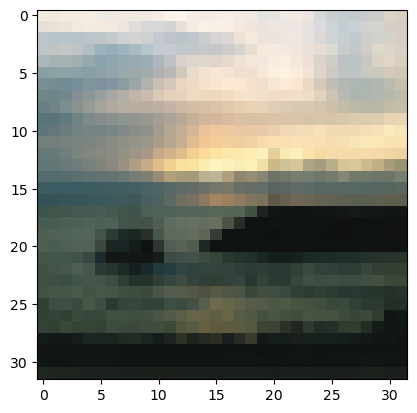

8


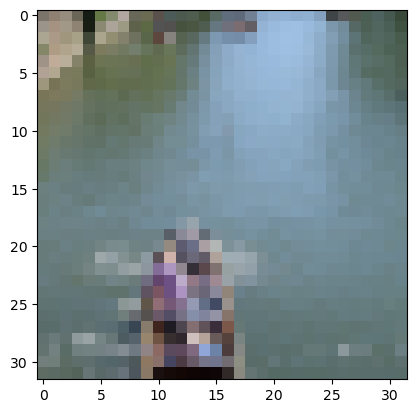

8


In [47]:
neighbor_image_paths = [image_paths[idx] for idx in indices[0]]
neighbor_labels = [labels[idx] for idx in indices[0]]
for path, label in zip(neighbor_image_paths, neighbor_labels):
    image = load_image(path)
    image = np.transpose(image, (1, 2, 0))
    show_image(image)
    print(label)